# Error Propegation
Here we are going to analyse how highly erroneous points get mapped onto the isochrones.

In [1]:
import pickle
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
os.chdir('..')
from star_sample import Isochrones,StarSample
os.chdir('Data')
pkl_file = open('isochrones_high_lat.pkl', 'rb')

Isochrone_hl = pickle.load(pkl_file)
os.chdir('..')

In [2]:
os.chdir('Data')
pkl_file = open('high_lat_values.pkl', 'rb')

High_Latitude_sample = pickle.load(pkl_file)
os.chdir('..')

# Cuts

In [3]:
High_Latitude_sample.data['G']=High_Latitude_sample.data['phot_g_mean_mag']-5*np.log10(High_Latitude_sample.data['r_med_geo'])+5
High_Latitude_sample.data['K']=High_Latitude_sample.data['ks_m']-5*np.log10(High_Latitude_sample.data['r_med_geo'])+5
High_Latitude_sample.data['jk']=High_Latitude_sample.data['j_m']-High_Latitude_sample.data['ks_m']

In [4]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']>3.6].reset_index(drop=True)
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']<5.1].reset_index(drop=True)

In [5]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['r_med_geo']<1000.0].reset_index(drop=True)


In [6]:
stacked_isochrones=Isochrone_hl.stack_isochrones()
x_values=High_Latitude_sample.to_tensor(expandsize=stacked_isochrones.shape[-2])

In [7]:
x_columns=High_Latitude_sample.data.columns
isoc_columns=Isochrone_hl.isochrones_list[0].columns
def column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0]

# Look at the HR diagram.

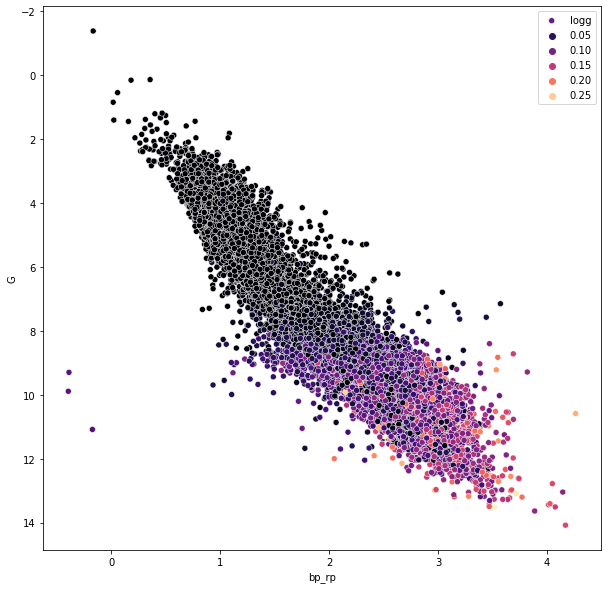

In [8]:
f, axes = plt.subplots(1,1)
f.set_figheight(10)
f.set_figwidth(10)

scatter=High_Latitude_sample.data

sn.scatterplot(x=scatter['bp_rp'],y=scatter['G'],hue=scatter['bp_rp_error'],ax=axes,label='logg',color='g',palette=sn.color_palette("magma", as_cmap=True))



#axes.set_xlim(0,2.5)
axes.invert_yaxis()



plt.legend()
#axes.set_title("Field Stars")
plt.show()

# First take a low error datapoint.

We want to look at how the error effects the region of the isochrone it gets mapped to. 

In [9]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['bp_rp_error']<0.005]
x_values=High_Latitude_sample.to_tensor(expandsize=stacked_isochrones.shape[-2])

In [10]:
single_source=x_values[11]

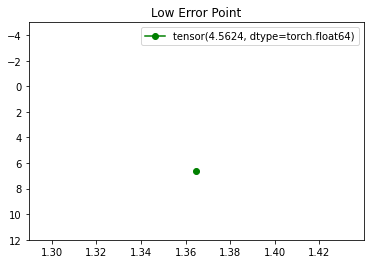

In [11]:
plt.title('Low Error Point')
plt.plot(single_source[2,column_index('bp_rp')],single_source[2,column_index('G')],label=single_source[2,column_index('logg_gspphot')],marker='o',c='g')
plt.ylim(12,-5)
plt.legend()

Reshape so that we can compare this point to every isochrone.

In [12]:
single_source_r=single_source.expand((len(stacked_isochrones),)+(single_source.shape))

In [13]:
single_source.shape

torch.Size([195, 38])

Bad practice but..

In [14]:
n_samples=5000
all_xints=[]
all_yints=[]
orig_x=[]
orig_y=[]

In [15]:
for i in range(n_samples):
    eps=np.random.standard_normal()
    single_source=x_values[11].clone()
    single_source_r=single_source.expand((len(stacked_isochrones),)+(single_source.shape))
    def column_index(name):
        if name in x_columns:
            return np.where(np.array(x_columns)==name)[0][0]
        else:
            return np.where(np.array(isoc_columns)==name)[0][0]
    single_source[:,column_index('G')]=single_source[:,column_index('G')]+eps*single_source[:,column_index('phot_g_mean_mag_error')]
    single_source[:,column_index('bp_rp')]=single_source[:,column_index('bp_rp')]+eps*single_source[:,column_index('bp_rp_error')]
    isochrone=torch.cat([single_source_r,stacked_isochrones],dim=-1)
    def column_index(name):
        if name in x_columns:
            return np.where(np.array(x_columns)==name)[0][0]
        else:
            return np.where(np.array(isoc_columns)==name)[0][0]+len(x_columns)
    truth_1=(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')]<=isochrone[:,:,column_index('high_c')]) #box selection
    truth_2=(isochrone[:,:,column_index('low_c')]<=isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')])
    truth=torch.logical_and(truth_1,truth_2)


    a1=-1*isochrone[:,:,column_index('slopes')]
    b1=1.0
    c1=isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('BPRP')]-isochrone[:,:,column_index('Gaia_G_EDR3')]


    a2=-1*isochrone[:,:,column_index('p_slopes')]
    b2=1.0
    c2=isochrone[:,:,column_index('p_slopes')]*isochrone[:,:,column_index('bp_rp')]-isochrone[:,:,column_index('G')]


    x=(b1*c2-b2*c1).clone()/(a1*b2-a2*b1).clone()
    y=(a2*c1-a1*c2).clone()/(a1*b2-a2*b1).clone()

    sgn=torch.sign((y.clone()-isochrone[:,:,column_index('G')].clone())/(x.clone()-isochrone[:,:,column_index('bp_rp')].clone()))

    d=torch.sqrt((x.clone()-isochrone[:,:,column_index('bp_rp')].clone())**2+(y.clone()-isochrone[:,:,column_index('G')].clone())**2)
    #for i in range(len(d)):
    #    plt.plot(d[i])
    #plt.title('Distance along reddening per component for each datapoint')
    idx=torch.argmin(torch.abs(d/truth.reshape(d.shape)).nan_to_num(nan=torch.inf),-1)

    sgn=sgn.gather(1,idx.view(-1,1))
    d=d.gather(1,idx.view(-1,1))*sgn
    x_ints=x.gather(1,idx.view(-1,1)).numpy()[:,0]
    y_ints=y.gather(1,idx.view(-1,1)).numpy()[:,0]
    all_xints.append(x_ints)
    all_yints.append(y_ints)
    orig_y.append(np.array(isochrone[:,0,column_index('G')]))
    orig_x.append(np.array(isochrone[:,0,column_index('bp_rp')]))


 First just take a random isochrone and see what the error propegation would mean.

In [16]:
isoc=10

In [17]:
all_xints=np.array(all_xints)
all_yints=np.array(all_yints)
orig_x=np.array(orig_x)
orig_y=np.array(orig_y)


In [18]:
orig_x.shape

(5000, 220)

In [19]:
one_iso=isochrone[isoc]
xs=all_xints[:,isoc]
ys=all_yints[:,isoc]

x=orig_x[:,0]
y=orig_y[:,0]



(array([  14.,   76.,  274.,  804., 1269., 1296.,  834.,  335.,   80.,
          18.]),
 array([1.34765153, 1.35102806, 1.35440459, 1.35778112, 1.36115765,
        1.36453418, 1.36791072, 1.37128725, 1.37466378, 1.37804031,
        1.38141684]),
 <BarContainer object of 10 artists>)

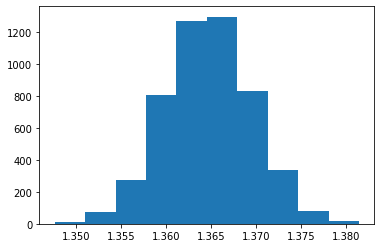

In [20]:
plt.hist(x)

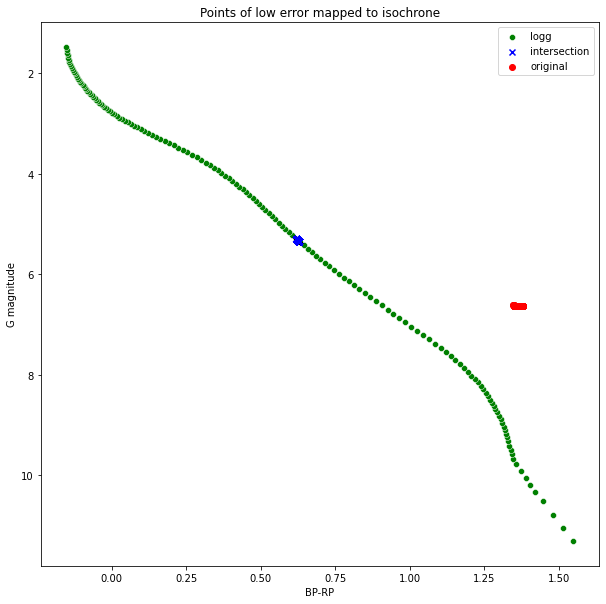

In [21]:
f, axes = plt.subplots(1,1)
f.set_figheight(10)
f.set_figwidth(10)

scatter=High_Latitude_sample.data

sn.scatterplot(x=one_iso[:,column_index('BPRP')],y=one_iso[:,column_index('Gaia_G_EDR3')],ax=axes,label='logg',color='g',palette=sn.color_palette("magma", as_cmap=True))
axes.scatter(xs,ys,marker='x',c='b',label='intersection')
axes.scatter(x,y,c='r',label='original')


#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
plt.title('Points of low error mapped to isochrone')
plt.ylabel('G magnitude')
plt.xlabel('BP-RP')
#axes.set_title("Field Stars")
plt.show()

In [22]:
dAg=x-xs

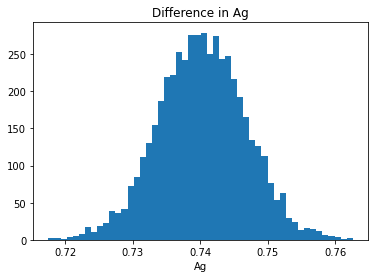

In [23]:
plt.hist(dAg,bins=50)
plt.title('Difference in Ag')
plt.xlabel('Ag')
plt.show()